In [17]:
import numpy as np
from numpy.polynomial import polynomial
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations
from tensorflow.keras.layers import Input, Dense,  Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras import regularizers

from tensorflow.keras import backend as K

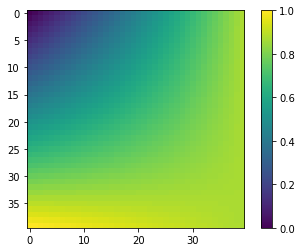

In [16]:
img = np.zeros((40,40), dtype=np.float)

#Function which creates the 2d iamges
def createImage(img, degree = 2):
    coeffs = [np.random.rand(degree) - 0.5, np.random.rand(degree) - 0.5]
    x, y = np.meshgrid(np.linspace(-1,1,img.shape[1]), np.linspace(-1,1,img.shape[0]))

    ret = polynomial.polyval2d(x, y, coeffs)

    #normalize..
    ret -= ret.min()
    ret = ret / ret.max()

    return ret

plt.imshow(createImage(img,2))
plt.colorbar()
plt.show()

Lets now built an enconder similar to the one from the lecture. First of all we just look at one with a single hidden layer

In [38]:
# this is the size of our encoded representations
encoding_dim = 10

# this is our input placeholder
input_img = Input(shape=(img.size,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(img.size, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [39]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [40]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [41]:
autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 1600)]            0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                16010     
_________________________________________________________________
dense_15 (Dense)             (None, 1600)              17600     
Total params: 33,610
Trainable params: 33,610
Non-trainable params: 0
_________________________________________________________________


In [46]:
autoencoder.compile(optimizer="adam", loss=keras.losses.binary_crossentropy)

# generate data
img = np.empty((40,40))
labels = np.array([
    createImage(img, degree=2).reshape(-1) for _ in range(10000)
])
labels2D = labels.reshape(-1, 40,40)

autoencoder.fit(labels, labels, epochs=12)

Train on 10000 samples
Epoch 1/12
10000/10000 [==============================] - 2s 171us/sample - loss: 0.5877
Epoch 2/12
10000/10000 [==============================] - 1s 127us/sample - loss: 0.5873
Epoch 3/12
10000/10000 [==============================] - 1s 141us/sample - loss: 0.5871
Epoch 4/12
10000/10000 [==============================] - 2s 178us/sample - loss: 0.5870
Epoch 5/12
10000/10000 [==============================] - 1s 128us/sample - loss: 0.5868
Epoch 6/12
10000/10000 [==============================] - 1s 129us/sample - loss: 0.5868
Epoch 7/12
10000/10000 [==============================] - 1s 130us/sample - loss: 0.5867
Epoch 8/12
10000/10000 [==============================] - 1s 131us/sample - loss: 0.5867
Epoch 9/12
10000/10000 [==============================] - 1s 136us/sample - loss: 0.5867
Epoch 10/12
10000/10000 [==============================] - 1s 137us/sample - loss: 0.5866
Epoch 11/12
10000/10000 [==============================] - 1s 132us/sample - loss: 0.5

In [63]:
encoded_imgs = encoder.predict(labels)
decoded_imgs = decoder.predict(encoded_imgs)

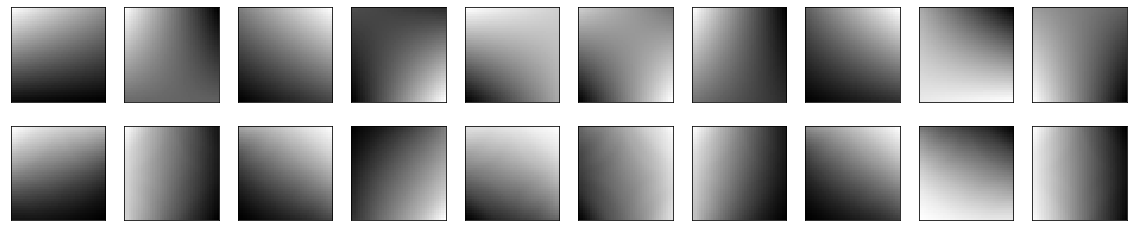

In [68]:
n = 10  # how many digits we will display

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(labels2D[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(40, 40))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We can see that these images are very similar. However, if you look very closely, differences can be seen. As an example the last image is a bit darker in the top left corner.

## Lets now built a autoenconder with 4 hidden layers

In [84]:
# building encoder

input_img = layers.Input(shape=(img.size,))

encoded = layers.Dense(128, activation=activations.relu)(input_img)
encoded = layers.Dense(64, activation=activations.relu)(input_img)
encoded = layers.Dense(32, activation=activations.relu)(input_img)
encoded = layers.Dense(2, activation=activations.relu)(input_img)

encoder = keras.Model(input_img, encoded)


In [85]:
# building decoder

encoded_input = layers.Input(shape=(2,))

#decoded = layers.Dense(32, activation=activations.relu)(encoded_input)
decoded = layers.Dense(64, activation=activations.relu)(encoded_input)
decoded = layers.Dense(128, activation=activations.relu)(decoded)
decoded = layers.Dense(img.size, activation=activations.relu)(decoded)

decoder = keras.Model(encoded_input, decoded)

In [86]:
# building autoencoder
autoencoder = keras.Model(input_img, decoder(encoder(input_img)))

In [87]:
autoencoder.summary()

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 1600)]            0         
_________________________________________________________________
model_22 (Model)             (None, 2)                 3202      
_________________________________________________________________
model_23 (Model)             (None, 1600)              214912    
Total params: 218,114
Trainable params: 218,114
Non-trainable params: 0
_________________________________________________________________


In [88]:
autoencoder.compile(optimizer="adam", loss=keras.losses.binary_crossentropy)
autoencoder.fit(labels, labels, epochs=12)

Train on 10000 samples
Epoch 1/12
10000/10000 [==============================] - 3s 294us/sample - loss: 2.8701
Epoch 2/12
10000/10000 [==============================] - 2s 234us/sample - loss: 2.4420
Epoch 3/12
10000/10000 [==============================] - 2s 197us/sample - loss: 2.4419
Epoch 4/12
10000/10000 [==============================] - 2s 201us/sample - loss: 2.4254
Epoch 5/12
10000/10000 [==============================] - 2s 200us/sample - loss: 2.4243
Epoch 6/12
10000/10000 [==============================] - 2s 208us/sample - loss: 2.4171
Epoch 7/12
10000/10000 [==============================] - 2s 197us/sample - loss: 2.4127
Epoch 8/12
10000/10000 [==============================] - 2s 199us/sample - loss: 2.4068
Epoch 9/12
10000/10000 [==============================] - 2s 199us/sample - loss: 2.4056
Epoch 10/12
10000/10000 [==============================] - 2s 208us/sample - loss: 2.0621
Epoch 11/12
10000/10000 [==============================] - 2s 200us/sample - loss: 2.0

In [89]:
encoded_imgs = encoder.predict(labels)
decoded_imgs = decoder.predict(encoded_imgs)

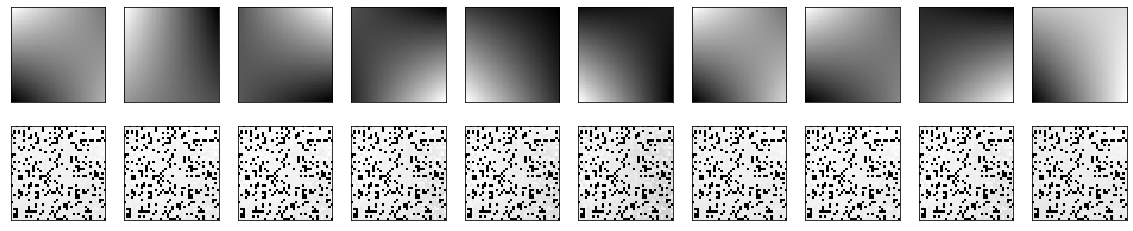

In [90]:
n = 10  # how many digits we will display

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(labels2D[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(40, 40))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Here we can see that the reconstructed images look very different. The first model was a much better fit